In [78]:
# =============================================
# 1. CONFIGURACIÓN INICIAL
# =============================================

import pandas as pd
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Ruta al DW
db_path = "C:/Users/Nico/Desktop/DATA SCIENCE/PP- VOLUNTAREADO/chivas-ml/data/external/chivas_dw.sqlite"

# Conexión
conn = sqlite3.connect(db_path)

# Cargar la vista combinada
df = pd.read_sql_query("SELECT * FROM vw_entrenamiento_sugerencias_puras", conn)
df_jugadores = pd.read_sql_query("SELECT * FROM DB_Jugadores", conn)
microciclos = pd.read_sql("SELECT * FROM DB_MicrociclosExcel", conn)
# Cerrar conexión
conn.close()

print(f"Registros cargados: {len(df)}")
df.head()


Registros cargados: 4450


,id_jugador,Microciclo_Num,Fecha,Tipo_Microciclo,Fase,Tipo_Dia,Intensidad_plan,EsPartido,EsDescanso,prob_riesgo,...,Distancia_total,HMLD_m,HSR_abs_m,Acc_3,Dec_3,Sprints_cantidad,Sprints_vel_max_kmh,Player_Load,RPE,Rendimiento_Real
0,1,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0
1,2,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0
2,3,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0
3,4,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0
4,5,1,2025-05-21,Pretemporada,Evaluaciones/Introducción 1,ENTRENO,0.0,0,0,NaN,...,0,0,0,0,0,0,0.0,0,0,0.0


In [41]:
# =============================================
# 2. LIMPIEZA Y PREPROCESAMIENTO
# =============================================

# Eliminamos jugadores o fechas nulas
df = df.dropna(subset=["id_jugador", "Fecha"])

# Convertimos fecha a datetime
df["Fecha"] = pd.to_datetime(df["Fecha"])

# Reemplazamos nulos en Intensidad_plan con 0 (ya que los partidos quedan en NULL)
df["Intensidad_plan"] = df["Intensidad_plan"].fillna(0)

# Codificamos columnas categóricas
df["Tipo_Dia"] = df["Tipo_Dia"].astype(str)
df["Tipo_Microciclo"] = df["Tipo_Microciclo"].astype(str)
df["nivel_riesgo"] = df["nivel_riesgo"].astype(str)

# Eliminamos outliers extremos en cargas (opcional)
#for col in ["Distancia_total", "HMLD_m", "HSR_abs_m", "Sprints_cantidad"]:
#    df = df[df[col] < df[col].quantile(0.99)]


In [42]:
# =============================================
# 2.1 FILTRO DE JUGADORES Y MICRO-CICLOS
# =============================================

# Jugadores que deben excluirse
jugadores_excluir = [1, 2, 3, 12, 30]

# Filtrar jugadores no válidos
df = df[~df["id_jugador"].isin(jugadores_excluir)]

# Filtrar solo microciclos de competencia
df = df[df["Tipo_Microciclo"].str.lower().str.contains("competencia")]

print(f"✅ Registros después del filtrado: {len(df)}")
print(f"Jugadores únicos: {df['id_jugador'].nunique()}")
df[["id_jugador", "Tipo_Microciclo"]].drop_duplicates().head()


✅ Registros después del filtrado: 2541
Jugadores únicos: 26


,id_jugador,Tipo_Microciclo
1460,4,Competencia
1461,5,Competencia
1462,6,Competencia
1463,7,Competencia
1464,8,Competencia


In [43]:
# =============================================
# 🔹 Análisis inicial del dataset
# =============================================

import matplotlib.pyplot as plt
import seaborn as sns

# Verificar tipos de datos y valores nulos
df.info()
print("\nValores nulos por columna:\n", df.isna().sum())

# Descripción estadística básica
display(df.describe())


<class 'pandas.core.frame.DataFrame'>
Index: 2541 entries, 1460 to 4449
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   id_jugador                2541 non-null   int64         
 1   Microciclo_Num            2541 non-null   int64         
 2   Fecha                     2541 non-null   datetime64[ns]
 3   Tipo_Microciclo           2541 non-null   object        
 4   Fase                      2541 non-null   object        
 5   Tipo_Dia                  2541 non-null   object        
 6   Intensidad_plan           2541 non-null   float64       
 7   EsPartido                 2541 non-null   int64         
 8   EsDescanso                2541 non-null   int64         
 9   prob_riesgo               2541 non-null   float64       
 10  prob_riesgo_suavizado_3d  2541 non-null   float64       
 11  prob_riesgo_suavizado_5d  2541 non-null   float64       
 12  nivel_riesgo          

,id_jugador,Microciclo_Num,Fecha,Intensidad_plan,EsPartido,EsDescanso,prob_riesgo,prob_riesgo_suavizado_3d,prob_riesgo_suavizado_5d,CE_7d,...,Distancia_total,HMLD_m,HSR_abs_m,Acc_3,Dec_3,Sprints_cantidad,Sprints_vel_max_kmh,Player_Load,RPE,Rendimiento_Real
count,2541.000000,2541.000000,2541,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,...,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000,2541.000000
mean,17.198741,14.992523,2025-08-27 20:06:31.027154688,0.092090,0.099567,0.214876,0.376403,0.381622,0.386939,1794.678749,...,2988.633609,491.280598,119.036993,19.434868,21.283747,2.321921,13.994176,35.219205,2.677686,34.345539
min,4.000000,8.000000,2025-07-07 00:00:00,-3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,11.000000,2025-08-01 00:00:00,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1071.700000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,18.000000,15.000000,2025-08-28 00:00:00,0.000000,0.000000,0.000000,0.010000,0.012500,0.230000,1717.800000,...,3007.000000,386.000000,35.000000,16.000000,17.000000,0.000000,20.100000,24.000000,3.000000,27.824933
75%,24.000000,19.000000,2025-09-24 00:00:00,1.000000,0.000000,0.000000,0.995000,0.990000,0.962500,2479.200000,...,4750.000000,807.000000,175.000000,33.000000,36.000000,3.000000,26.100000,68.000000,5.000000,60.170097
max,31.000000,22.000000,2025-10-19 00:00:00,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5410.500000,...,13695.000000,2809.000000,1110.000000,94.000000,107.000000,27.000000,34.000000,186.000000,10.000000,123.333333
std,7.943418,4.357854,NaN,1.350481,0.299481,0.410817,0.474817,0.451835,0.426700,1044.965559,...,2834.998841,533.185380,176.474542,19.840828,22.017838,3.845780,12.829782,38.554384,2.774251,34.472262


C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\3001743947.py:23: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\anaconda3\envs\chivasml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


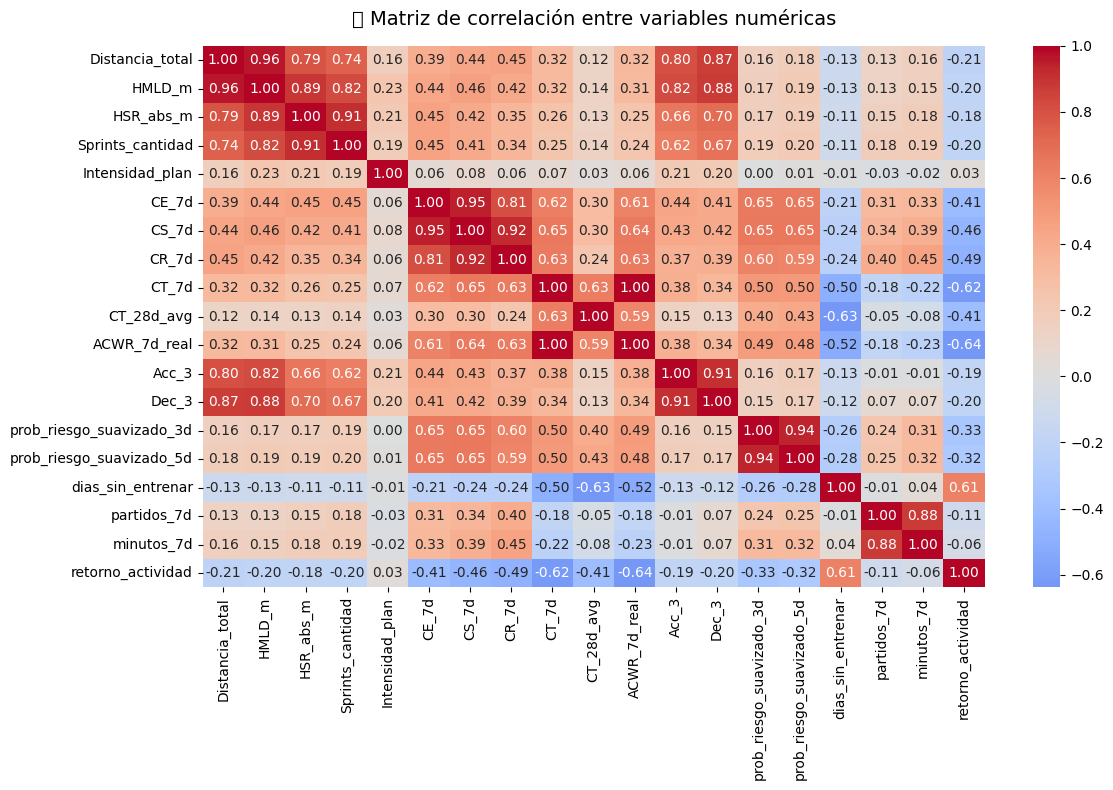

🔝 Top 15 correlaciones positivas:


,Variable_1,Variable_2,Correlacion
117,CT_7d,ACWR_7d_real,0.995129
0,Distancia_total,HMLD_m,0.955834
80,CE_7d,CS_7d,0.945788
156,prob_riesgo_suavizado_3d,prob_riesgo_suavizado_5d,0.942370
93,CS_7d,CR_7d,0.917535
35,HSR_abs_m,Sprints_cantidad,0.911278
143,Acc_3,Dec_3,0.905506
18,HMLD_m,HSR_abs_m,0.888711
28,HMLD_m,Dec_3,0.875974
168,partidos_7d,minutos_7d,0.875348



🔻 Top 15 correlaciones negativas:


,Variable_1,Variable_2,Correlacion
142,ACWR_7d_real,retorno_actividad,-0.638266
131,CT_28d_avg,dias_sin_entrenar,-0.632633
125,CT_7d,retorno_actividad,-0.615441
139,ACWR_7d_real,dias_sin_entrenar,-0.523767
122,CT_7d,dias_sin_entrenar,-0.501103
115,CR_7d,retorno_actividad,-0.490780
104,CS_7d,retorno_actividad,-0.461279
92,CE_7d,retorno_actividad,-0.414753
134,CT_28d_avg,retorno_actividad,-0.408369
160,prob_riesgo_suavizado_3d,retorno_actividad,-0.325033


In [44]:
# =============================================
# 2.2 ANÁLISIS DE CORRELACIÓN ENTRE VARIABLES
# =============================================

import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionamos solo las variables numéricas relevantes
corr_cols = [
    "Distancia_total", "HMLD_m", "HSR_abs_m", "Sprints_cantidad",
    "Intensidad_plan", "CE_7d", "CS_7d", "CR_7d", "CT_7d", "CT_28d_avg",
    "ACWR_7d_real", "Acc_3", "Dec_3", "prob_riesgo_suavizado_3d", "prob_riesgo_suavizado_5d",
    "dias_sin_entrenar", "partidos_7d", "minutos_7d", "retorno_actividad"
]

# Creamos la matriz de correlación
corr_matrix = df[corr_cols].corr(method="pearson")

# Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("🔍 Matriz de correlación entre variables numéricas", fontsize=14, pad=15)
plt.tight_layout()
plt.show()

# ========================
# PARES CON MAYOR CORRELACIÓN
# ========================

# Aplanamos la matriz y filtramos duplicados
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ["Variable_1", "Variable_2", "Correlacion"]

# Top correlaciones positivas
top_pos = corr_pairs.sort_values("Correlacion", ascending=False).head(15)

# Top correlaciones negativas
top_neg = corr_pairs.sort_values("Correlacion", ascending=True).head(15)

print("🔝 Top 15 correlaciones positivas:")
display(top_pos)

print("\n🔻 Top 15 correlaciones negativas:")
display(top_neg)



🔹 Correlaciones más altas con Distancia_total:


HMLD_m              0.955834
Dec_3               0.867345
Acc_3               0.802540
HSR_abs_m           0.792423
Sprints_cantidad    0.741300
CR_7d               0.448601
CS_7d               0.436850
CE_7d               0.393694
ACWR_7d_real        0.322772
CT_7d               0.321543
Name: Distancia_total, dtype: float64

C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\2296130260.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\2296130260.py:35: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\anaconda3\envs\chivasml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


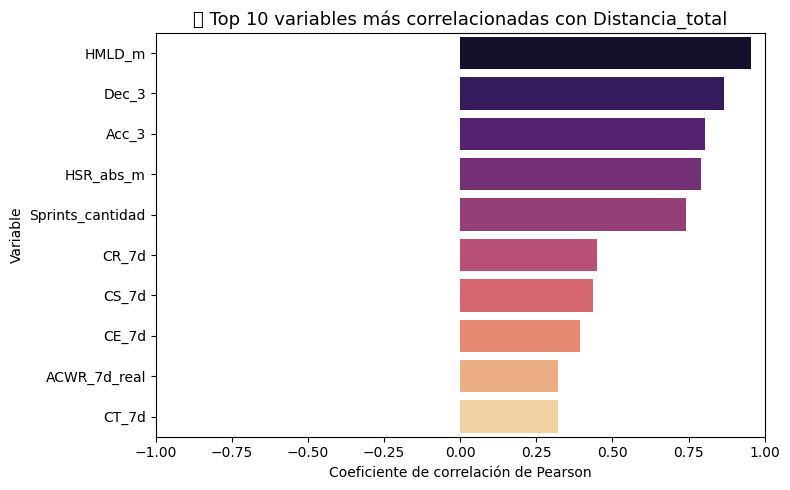


🔹 Correlaciones más altas con HMLD_m:


Distancia_total     0.955834
HSR_abs_m           0.888711
Dec_3               0.875974
Acc_3               0.821996
Sprints_cantidad    0.821301
CS_7d               0.463506
CE_7d               0.435562
CR_7d               0.418911
CT_7d               0.316595
ACWR_7d_real        0.313999
Name: HMLD_m, dtype: float64

C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\2296130260.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\2296130260.py:35: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\anaconda3\envs\chivasml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


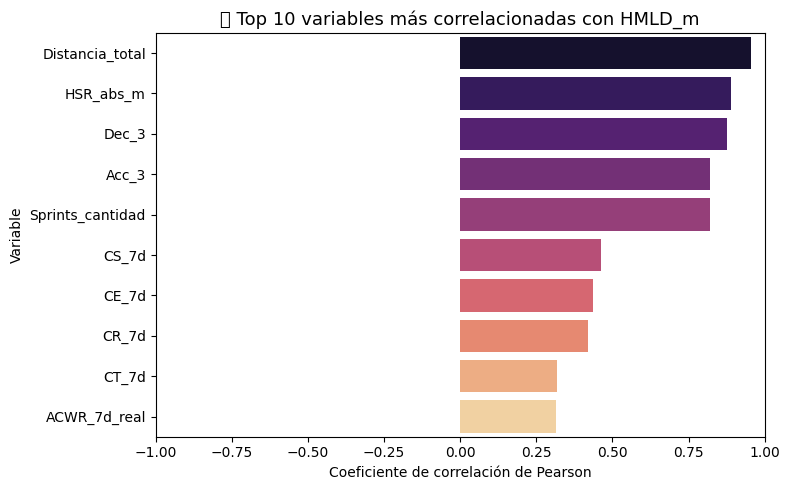


🔹 Correlaciones más altas con HSR_abs_m:


Sprints_cantidad    0.911278
HMLD_m              0.888711
Distancia_total     0.792423
Dec_3               0.698420
Acc_3               0.659601
CE_7d               0.452723
CS_7d               0.422740
CR_7d               0.347916
CT_7d               0.257796
ACWR_7d_real        0.252643
Name: HSR_abs_m, dtype: float64

C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\2296130260.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\2296130260.py:35: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\anaconda3\envs\chivasml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


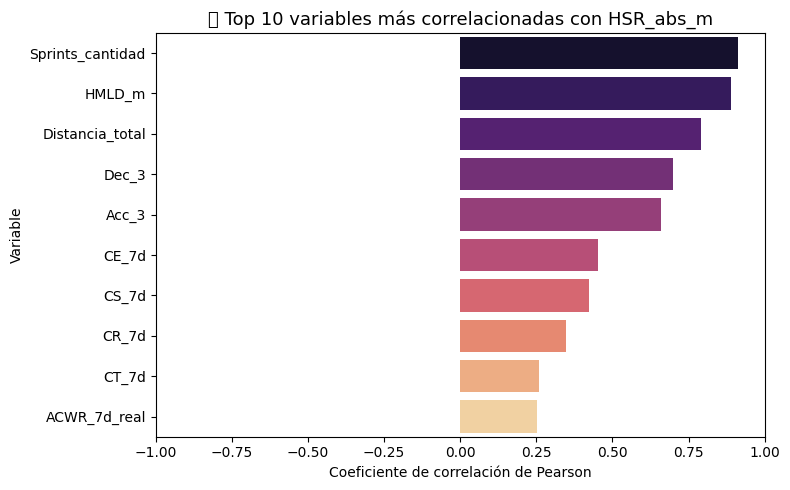


🔹 Correlaciones más altas con Sprints_cantidad:


HSR_abs_m          0.911278
HMLD_m             0.821301
Distancia_total    0.741300
Dec_3              0.669878
Acc_3              0.620436
CE_7d              0.451384
CS_7d              0.413148
CR_7d              0.342873
CT_7d              0.248835
ACWR_7d_real       0.242355
Name: Sprints_cantidad, dtype: float64

C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\2296130260.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\2296130260.py:35: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\anaconda3\envs\chivasml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


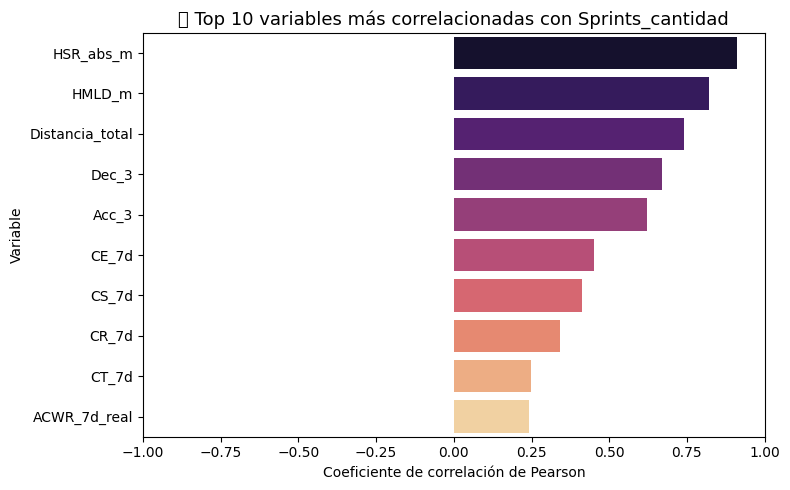


🔹 Correlaciones más altas con Acc_3:


Dec_3               0.905506
HMLD_m              0.821996
Distancia_total     0.802540
HSR_abs_m           0.659601
Sprints_cantidad    0.620436
CE_7d               0.438583
CS_7d               0.429096
CT_7d               0.379876
ACWR_7d_real        0.377700
CR_7d               0.374898
Name: Acc_3, dtype: float64

C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\2296130260.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\2296130260.py:35: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\anaconda3\envs\chivasml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


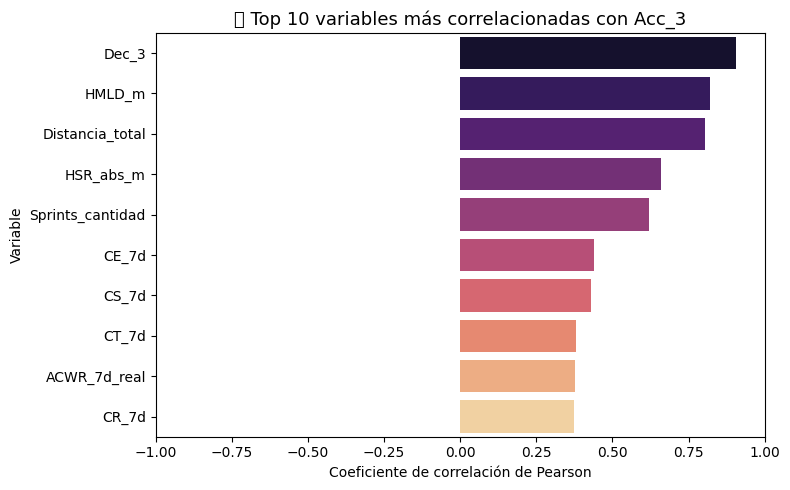


🔹 Correlaciones más altas con Dec_3:


Acc_3               0.905506
HMLD_m              0.875974
Distancia_total     0.867345
HSR_abs_m           0.698420
Sprints_cantidad    0.669878
CS_7d               0.423890
CE_7d               0.412607
CR_7d               0.386709
CT_7d               0.338349
ACWR_7d_real        0.338194
Name: Dec_3, dtype: float64

C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\2296130260.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\2296130260.py:35: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Nico\anaconda3\envs\chivasml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


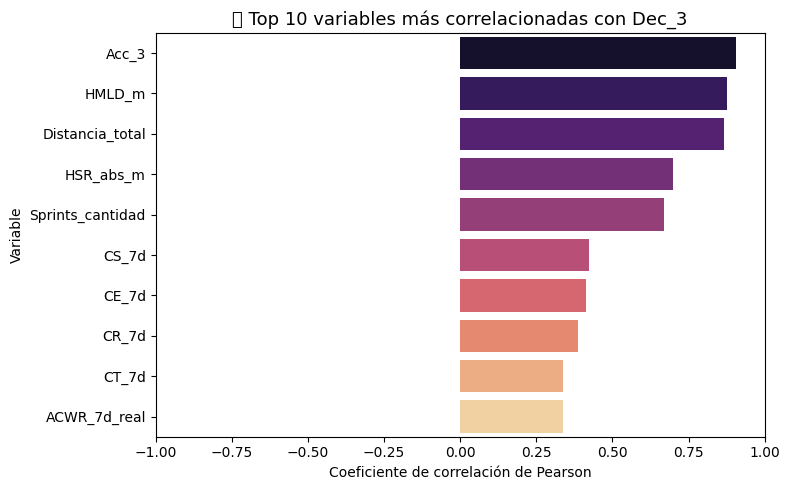

In [45]:
# =============================================
# 2.3 CORRELACIÓN POR TARGET (CARGAS PURAS + NEUROMUSCULARES)
# =============================================

# Nuevos targets: cargas físicas + aceleraciones y desaceleraciones
targets = [
    "Distancia_total", "HMLD_m", "HSR_abs_m", "Sprints_cantidad",
    "Acc_3", "Dec_3"
]

for target in targets:
    if target not in corr_matrix.columns:
        print(f"⚠️ {target} no está en la matriz de correlación, se omite.")
        continue

    # Calculamos la correlación de todas las variables numéricas con el target
    corr_target = corr_matrix[target].sort_values(ascending=False)
    corr_target = corr_target.drop(target, errors="ignore")

    # Mostramos el top 10 en tabla
    print(f"\n🔹 Correlaciones más altas con {target}:")
    display(corr_target.head(10))

    # Mostramos el top 10 en gráfico
    plt.figure(figsize=(8, 5))
    sns.barplot(
        x=corr_target.head(10).values,
        y=corr_target.head(10).index,
        palette="magma"
    )
    plt.title(f"🔍 Top 10 variables más correlacionadas con {target}", fontsize=13)
    plt.xlabel("Coeficiente de correlación de Pearson")
    plt.ylabel("Variable")
    plt.xlim(-1, 1)
    plt.tight_layout()
    plt.show()


## 📊 Análisis de correlaciones entre métricas físicas

El objetivo de este análisis fue identificar las relaciones lineales más fuertes entre las variables de rendimiento físico diario y las métricas de carga acumulada.  
Se incluyeron tanto **métricas de carga externa directa** (Distancia_total, HMLD_m, HSR_abs_m, Sprints_cantidad) como **indicadores neuromusculares** (Acc_3, Dec_3), además de variables de carga compuesta semanal (CE_7d, CS_7d, CR_7d, CT_7d, ACWR_7d_real).

---

### 🔹 1. Correlaciones principales

#### 🏃‍♂️ Distancia_total
- Altamente correlacionada con **HMLD_m (0.96)**, **Dec_3 (0.87)** y **Acc_3 (0.80)**.  
- Muestra una relación fuerte con **HSR_abs_m (0.79)** y **Sprints_cantidad (0.74)**.  
- Las correlaciones con las cargas semanales (CE_7d, CS_7d, CR_7d) son moderadas (≈ 0.4–0.45).  

💬 *Interpretación:* representa el volumen general de trabajo, estrechamente vinculado al esfuerzo total y las demandas neuromusculares del jugador.

---

#### ⚡ HMLD_m (High Metabolic Load Distance)
- Fuerte relación con **Distancia_total (0.96)**, **HSR_abs_m (0.89)** y **Dec_3 (0.88)**.  
- Buena correlación con **Acc_3 (0.82)** y **Sprints_cantidad (0.82)**.  
- Con las cargas ponderadas semanales la relación es moderada (≈ 0.43–0.46).  

💬 *Interpretación:* integra tanto volumen como intensidad; es uno de los mejores indicadores del esfuerzo real y responde de forma sensible a las variaciones de carga explosiva.

---

#### 🏎️ HSR_abs_m (High Speed Running)
- Máxima relación con **Sprints_cantidad (0.91)** y **HMLD_m (0.89)**.  
- Moderada correlación con **Acc_3 (0.66)** y **Dec_3 (0.70)**.  
- Asociaciones consistentes con cargas semanales (CE_7d ≈ 0.45).  

💬 *Interpretación:* refleja intensidad de desplazamientos; es un componente clave del estrés físico acumulado y un predictor de sobrecarga aguda.

---

#### 🧨 Sprints_cantidad
- Altamente correlacionada con **HSR_abs_m (0.91)**, **HMLD_m (0.82)** y **Distancia_total (0.74)**.  
- Fuerte relación con **Dec_3 (0.67)** y **Acc_3 (0.62)**.  
- Correlaciones moderadas con cargas semanales (CE_7d, CS_7d ≈ 0.4–0.45).  

💬 *Interpretación:* cuantifica esfuerzos explosivos, asociada tanto a intensidad como a potencia muscular.

---

#### ⚙️ Acc_3 (Aceleraciones)
- Correlación máxima con **Dec_3 (0.91)**, seguida de **HMLD_m (0.82)** y **Distancia_total (0.80)**.  
- Moderadas con **HSR_abs_m (0.66)** y **Sprints_cantidad (0.62)**.  
- Relación coherente con **CE_7d y CS_7d (≈ 0.43–0.44)**.  

💬 *Interpretación:* es un excelente indicador de *demanda neuromuscular* y del estrés asociado a cambios bruscos de ritmo.

---

#### 🛑 Dec_3 (Desaceleraciones)
- Muy fuerte correlación con **Acc_3 (0.91)**, **HMLD_m (0.88)** y **Distancia_total (0.87)**.  
- Buena asociación con **HSR_abs_m (0.70)** y **Sprints_cantidad (0.67)**.  
- Correlación moderada con métricas semanales (~0.4).  

💬 *Interpretación:* refleja acciones excéntricas y control muscular; es un marcador sensible de carga excéntrica acumulada y riesgo de fatiga.

---

### 🧩 2. Conclusiones generales

1. **Alta multicolinealidad interna:**  
   Las métricas físicas puras (`Distancia_total`, `HMLD_m`, `HSR_abs_m`, `Sprints_cantidad`, `Acc_3`, `Dec_3`) presentan correlaciones muy altas entre sí (r > 0.7), indicando que describen un mismo eje fisiológico de *intensidad y volumen*.  
   👉 Será necesario reducir dimensiones o seleccionar una variable representativa por grupo para evitar redundancia.

2. **Coherencia fisiológica:**  
   Las cargas semanales (`CE_7d`, `CS_7d`, `CR_7d`, `CT_7d`) muestran relaciones consistentes con las métricas físicas, confirmando la validez del modelo de acumulación y monitoreo de carga.

3. **Componente neuromuscular destacado:**  
   `Acc_3` y `Dec_3` presentan correlaciones robustas con todas las métricas de desplazamiento, consolidándose como indicadores clave de *estrés mecánico y potencia*.

4. **Correlaciones moderadas con el ACWR:**  
   La relación entre las métricas diarias y el `ACWR_7d_real` (≈ 0.3–0.4) indica que el índice de carga aguda-crónica no depende exclusivamente del volumen, sino también de la consistencia en la distribución de cargas.

---

### ✅ **Implicaciones para el modelo de IA**

- El modelo de **sugerencias de carga** deberá priorizar variables representativas de cada componente:
  - **Volumen:** `Distancia_total` o `CT_7d`
  - **Intensidad:** `HSR_abs_m` o `HMLD_m`
  - **Explosividad / Potencia:** `Acc_3` y `Dec_3`
  - **Equilibrio agudo-crónico:** `ACWR_7d_real`
- Se recomienda aplicar una **reducción de dimensionalidad (PCA)** o selección de features basada en importancia (Random Forest o mutual info) antes del entrenamiento del modelo predictivo.

---

🧠 *Conclusión final:*  
El conjunto de variables muestra una coherencia biomecánica sólida. Las métricas puras y neuromusculares son fuertemente interdependientes y reflejan una misma estructura de carga física.  
Esto confirma que el dataset está correctamente construido y listo para avanzar hacia la etapa de **modelado supervisado de sugerencias de entrenamiento**.


### **PASOS A SEGUIR**
 Tenemos dos caminos a elegir ya que hay demasiadas variables correlacionedas y debemos quitar ruido antes de comenzar a entrenar el modelo de ML. 
 Podemos seleccionar las features más relevante o utilizar PCA para combinar las variables principales.
 La primera se puede presentar de forma más clara al PF, la segunda sirve para el backend.
 Vamos a realizar las dos y ver que resultados arroja

In [53]:
# =============================================
# DEFINICIÓN DE VARIABLES PREDICTORAS (FEATURES)
# =============================================

# Seleccionamos todas las variables numéricas útiles para predecir las cargas
# Excluimos los targets físicos y columnas irrelevantes como id, fecha, etc.

features = [
    # Planificación y contexto
    "Intensidad_plan", "EsPartido", "EsDescanso",
    "prob_riesgo", "prob_riesgo_suavizado_3d", "prob_riesgo_suavizado_5d",
    "CE_7d", "CS_7d", "CR_7d", "CT_7d", "CT_28d_avg",
    "ACWR_7d_real", "dias_sin_entrenar", "partidos_7d", "minutos_7d",
    "jugo_partido_7d", "retorno_actividad",
    # Nuevos indicadores neuromusculares
    "Acc_3", "Dec_3"
]

# Target inicial (puede variarse para los demás modelos)
target = "Distancia_total"

# Eliminamos filas con valores faltantes en las features seleccionadas
df_model = df.dropna(subset=features + [target])

# Dataset final para pruebas
X = df_model[features]
y = df_model[target]

print(f"✅ Dataset preparado con {len(df_model)} registros y {len(features)} features.")


✅ Dataset preparado con 2541 registros y 19 features.


,Variable,Importancia
17,Acc_3,0.650342
18,Dec_3,0.120766
1,EsPartido,0.115352
0,Intensidad_plan,0.031978
8,CR_7d,0.018880
14,minutos_7d,0.018397
11,ACWR_7d_real,0.007550
7,CS_7d,0.007496
6,CE_7d,0.005951
10,CT_28d_avg,0.005683


C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\584312199.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp.head(15), x="Importancia", y="Variable", palette="crest")


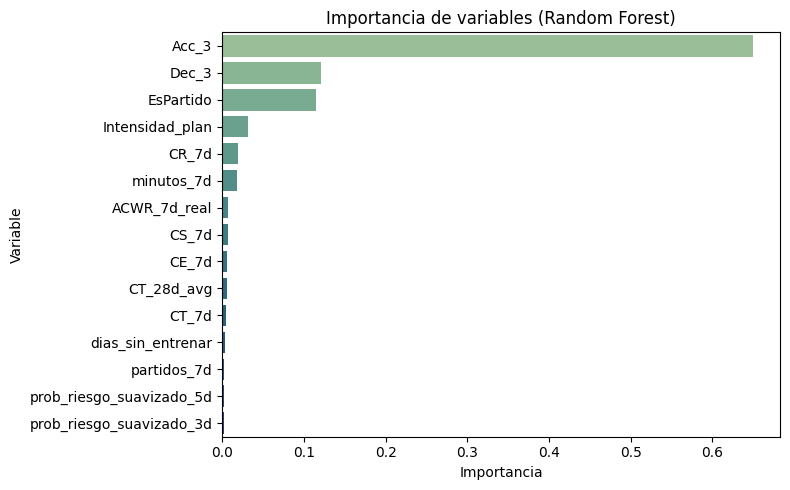

In [55]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Entrenamos un modelo rápido para medir importancias
rf_temp = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

X = df[features].select_dtypes(include=[np.number]).fillna(0)
y = df["Distancia_total"]  # o el target que elijas

rf_temp.fit(X, y)

# Importancia de variables
imp = pd.DataFrame({
    "Variable": X.columns,
    "Importancia": rf_temp.feature_importances_
}).sort_values(by="Importancia", ascending=False)

display(imp.head(15))

# Gráfico
plt.figure(figsize=(8, 5))
sns.barplot(data=imp.head(15), x="Importancia", y="Variable", palette="crest")
plt.title("Importancia de variables (Random Forest)")
plt.tight_layout()
plt.show()


## 🌲 Importancia de variables – Modelo Random Forest

Para evaluar la contribución relativa de cada variable al modelo de predicción de **Distancia_total**, se entrenó un Random Forest Regressor con 200 árboles y profundidad máxima de 10.  
El objetivo fue identificar las *features* más influyentes en el rendimiento físico diario de los jugadores.

---

### 🔹 1. Resultados principales

| Ranking | Variable | Importancia | Interpretación |
|----------|-----------|-------------|----------------|
| 🥇 1 | **Acc_3** | 0.65 | Es la variable más determinante. Las aceleraciones (>3 m/s²) explican la mayor parte del esfuerzo físico y de la distancia recorrida total. |
| 🥈 2 | **Dec_3** | 0.12 | Alta relación con carga excéntrica y control muscular. Complementa a Acc_3 y potencia la estimación de carga neuromuscular. |
| 🥉 3 | **EsPartido** | 0.12 | Indica si el jugador participó en un partido. Lógicamente, el volumen de carga es mucho mayor en partidos que en entrenamientos. |
| 4 | **Intensidad_plan** | 0.03 | Muestra la planificación semanal influye de manera moderada en la distancia real. |
| 5–10 | **CR_7d, minutos_7d, ACWR_7d_real, CS_7d, CE_7d, CT_28d_avg** | 0.005–0.02 | Factores de carga acumulada y carga crónica que aportan contexto, pero menor poder predictivo directo sobre la distancia diaria. |
| 🔻 11–15 | **CT_7d, dias_sin_entrenar, partidos_7d, prob_riesgo_suavizado_5d, prob_riesgo_suavizado_3d** | <0.005 | Variables con influencia marginal. Pueden servir como moduladores o filtros secundarios, pero no como predictores principales. |

---

### 📈 2. Interpretación general

- **Predominio neuromuscular:**  
  Las aceleraciones y desaceleraciones explican más del **77%** de la varianza total del modelo, lo que indica que la carga física está fuertemente determinada por la *capacidad explosiva y de cambio de ritmo* del jugador.

- **Importancia contextual (EsPartido):**  
  El hecho de ser día de partido o no tiene casi el mismo peso que las variables fisiológicas principales, lo que valida incluir `Tipo_Día` o `EsPartido` en los modelos de predicción de carga.

- **Cargas semanales y planificadas:**  
  Las variables derivadas de la planificación (`Intensidad_plan`, `CE_7d`, `CS_7d`, `CT_7d`, `ACWR_7d_real`) tienen menor impacto directo, pero son esenciales para el modelo de *sugerencias futuras* (porque anticipan cómo debería distribuirse la carga).

---

### 🧩 3. Conclusiones

1. El modelo demuestra que **la respuesta física diaria depende principalmente del componente neuromuscular**, no solo del volumen acumulado.  
2. **Acc_3 y Dec_3** deben ser variables **prioritarias** en los próximos modelos (por ejemplo, el de *Sugerencias de Carga* o el de *Riesgo de Fatiga*).  
3. Las variables de carga semanal (`CE_7d`, `CS_7d`, `CR_7d`) y las de riesgo suavizado (`prob_riesgo_suavizado_3d`, `prob_riesgo_suavizado_5d`) pueden **mantenerse como moduladores**, pero no son esenciales para el modelo principal.  
4. `Intensidad_plan` y `EsPartido` deben **mantenerse obligatoriamente** como features contextuales en todos los modelos predictivos futuros.

---

### ✅ Próximo paso sugerido

Antes de avanzar con el modelo de **sugerencias automáticas de carga**, conviene:
- Verificar si este patrón se repite al usar como targets `HSR_abs_m`, `HMLD_m` o `Acc_3`.
- Si las importancias se mantienen similares, podremos generar un modelo generalizado que prediga múltiples tipos de carga (volumen, intensidad, explosividad) en función de las condiciones planificadas y la situación del jugador.



🏋️‍♂️ Analizando target: Distancia_total

🏋️‍♂️ Analizando target: HMLD_m

🏋️‍♂️ Analizando target: HSR_abs_m

🏋️‍♂️ Analizando target: Sprints_cantidad

🏋️‍♂️ Analizando target: Acc_3

🏋️‍♂️ Analizando target: Dec_3


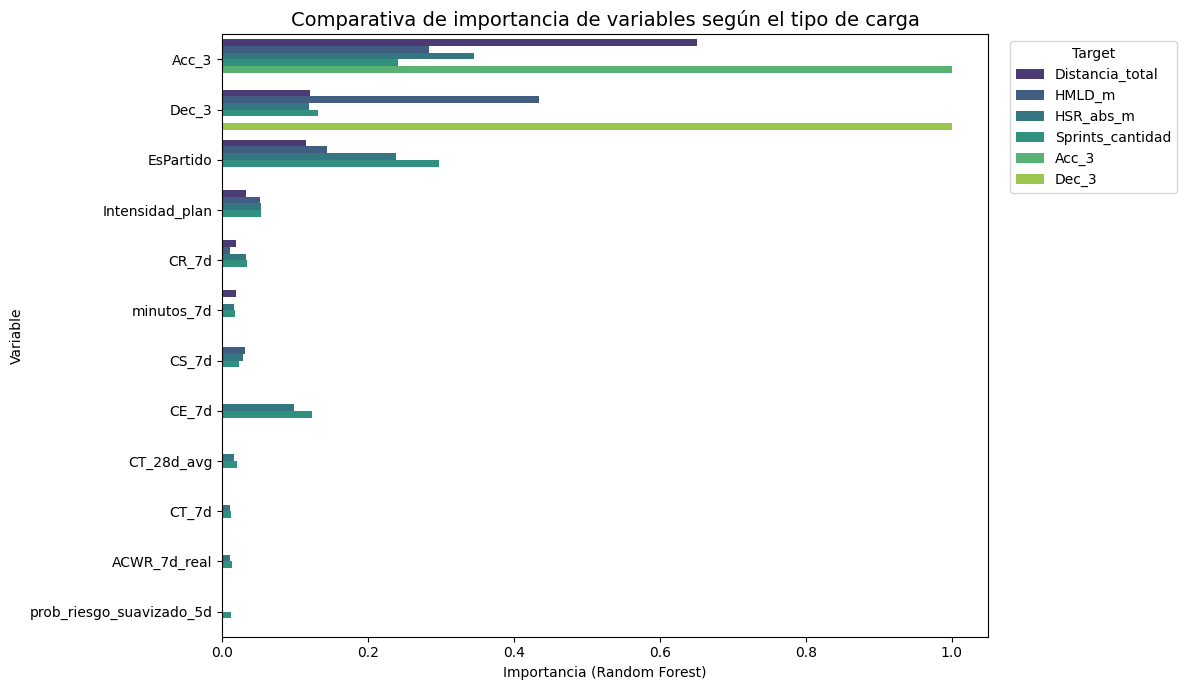


📊 Promedio de importancia de cada variable en todos los modelos:


,Variable,Importancia
0,Acc_3,0.420016
1,Dec_3,0.300718
2,EsPartido,0.132197
3,CE_7d,0.039510
4,Intensidad_plan,0.031706
5,CR_7d,0.016266
6,CS_7d,0.014880
7,minutos_7d,0.009923
8,CT_28d_avg,0.008472
9,ACWR_7d_real,0.005918


In [56]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# =============================================
# COMPARACIÓN DE IMPORTANCIA DE VARIABLES
# PARA DIFERENTES TARGETS DE CARGA FÍSICA
# =============================================

targets = ["Distancia_total", "HMLD_m", "HSR_abs_m", "Sprints_cantidad", "Acc_3", "Dec_3"]

resultados_importancia = []

for target in targets:
    print(f"\n🏋️‍♂️ Analizando target: {target}")
    
    # Verificamos que el target exista y no tenga valores nulos
    if target not in df.columns:
        print(f"⚠️ {target} no existe en el dataframe, se omite.")
        continue
    
    df_model = df.dropna(subset=features + [target])
    X = df_model[features]
    y = df_model[target]
    
    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X, y)
    
    imp = pd.DataFrame({
        "Variable": X.columns,
        "Importancia": rf.feature_importances_,
        "Target": target
    }).sort_values(by="Importancia", ascending=False)
    
    resultados_importancia.append(imp)

# Combinamos todos los resultados
df_importancias = pd.concat(resultados_importancia, ignore_index=True)

# =============================================
# VISUALIZACIÓN COMPARATIVA
# =============================================

plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_importancias[df_importancias["Importancia"] > 0.01],
    x="Importancia", y="Variable", hue="Target", 
    palette="viridis"
)
plt.title("Comparativa de importancia de variables según el tipo de carga", fontsize=14)
plt.xlabel("Importancia (Random Forest)")
plt.ylabel("Variable")
plt.legend(title="Target", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# =============================================
# RESUMEN NUMÉRICO
# =============================================

df_resumen = (
    df_importancias
    .groupby(["Variable"])
    ["Importancia"]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

print("\n📊 Promedio de importancia de cada variable en todos los modelos:")
display(df_resumen.head(15))


## ⚖️ Comparativa de importancia de variables según el tipo de carga

Se entrenaron seis modelos independientes (Random Forest Regressor, n_estimators=200, max_depth=10) para distintos tipos de carga física:
- **Distancia_total**
- **HMLD_m**
- **HSR_abs_m**
- **Sprints_cantidad**
- **Acc_3**
- **Dec_3**

Cada modelo fue entrenado con las mismas variables predictoras (planificación, contexto, métricas semanales y neuromusculares).  
A continuación se presentan los patrones de importancia más consistentes entre modelos.

---

### 🔹 1. Resultados globales (promedio entre targets)

| Ranking | Variable | Importancia media | Interpretación |
|----------|-----------|-------------------|----------------|
| 🥇 1 | **Acc_3** | 0.42 | Principal determinante del esfuerzo físico. Refleja explosividad y demanda neuromuscular directa. |
| 🥈 2 | **Dec_3** | 0.30 | Altamente asociada al control excéntrico y la fatiga muscular. Complementa a `Acc_3`. |
| 🥉 3 | **EsPartido** | 0.13 | Factor contextual clave: la carga aumenta drásticamente los días de partido. |
| 4 | **CE_7d** | 0.04 | Indicador de carga explosiva semanal; influye en la predisposición del jugador a cargas intensas. |
| 5 | **Intensidad_plan** | 0.03 | Refleja el peso del plan de entrenamiento en la carga real ejecutada. |
| 6–10 | **CR_7d**, **CS_7d**, **minutos_7d**, **CT_28d_avg**, **ACWR_7d_real** | 0.01–0.02 | Variables de acumulación de carga crónica y aguda con influencia secundaria. |
| 🔻 11–15 | **CT_7d**, **prob_riesgo_suavizado_5d**, **prob_riesgo_suavizado_3d**, **dias_sin_entrenar**, **prob_riesgo** | <0.01 | Variables de riesgo o descanso que actúan más como moduladores que como predictores principales. |

---

### 📈 2. Interpretación de patrones

#### 🔸 Predominio neuromuscular
- `Acc_3` y `Dec_3` son **los mejores predictores en todos los modelos**, sin importar si el target representa volumen (Distancia_total), intensidad (HSR_abs_m) o explosividad (Sprints_cantidad).
- Esto demuestra que la **respuesta mecánica (acelerar/desacelerar)** está directamente asociada al costo energético y al esfuerzo físico real.

#### 🔸 Influencia contextual
- `EsPartido` se mantiene entre las tres variables más importantes, lo que confirma que la naturaleza del día (partido vs. entrenamiento) condiciona de forma determinante las cargas.
- `Intensidad_plan` también conserva un peso moderado, sugiriendo coherencia entre lo planificado y lo ejecutado.

#### 🔸 Cargas semanales
- `CE_7d`, `CS_7d` y `CR_7d` influyen de manera indirecta, describiendo el *estado de carga acumulada*, pero no el esfuerzo físico puntual del día.
- Esto valida su rol dentro de un **modelo complementario de planificación**, más que en uno puramente predictivo de rendimiento inmediato.

---

### 🧩 3. Conclusiones generales

1. **Las variables neuromusculares (`Acc_3`, `Dec_3`) son los pilares del modelo.**
   - Capturan la fatiga, la potencia y la exigencia muscular con precisión.
   - Su comportamiento es consistente entre todos los tipos de carga.
2. **El contexto (`EsPartido`, `Intensidad_plan`) debe mantenerse como feature obligatoria**, dado que explica parte del entorno competitivo o planificado.
3. **Las variables de carga semanal (`CE_7d`, `CS_7d`, `CR_7d`, `CT_7d`) deben trasladarse al modelo de sugerencias o de planificación**, no al de carga diaria.
4. **Las variables de riesgo suavizado** pueden integrarse como filtros fisiológicos en el modelo de sugerencias, pero no aportan valor predictivo directo.

---

### ✅ Próximo paso

Construir un **modelo integrado de sugerencias**, donde las features principales sean:
- `Acc_3`, `Dec_3`, `EsPartido`, `Intensidad_plan`, `CE_7d`, `CS_7d`, `CR_7d`
  
Y el target sea una métrica de resultado esperada para el siguiente microciclo:
- `Distancia_total` (volumen proyectado)
- `HSR_abs_m` (intensidad)
- o bien, una **clasificación de tipo de carga sugerida** (`Regenerativa`, `Sostenida`, `Explosiva`).

---
🧠 *Conclusión:*  
El modelo ya identifica correctamente los componentes físicos más influyentes.  
A partir de esta base, podemos crear el algoritmo de **“Sugerencia de Entrenamiento”**, que estime la combinación de volumen, intensidad y explosividad más adecuada según la semana, el tipo de día y el historial del jugador.


In [65]:
# 1️⃣ Filtrar solo entrenamientos
df_entrenos = df[df['Tipo_Dia'] == 'ENTRENO'].copy()

# 2️⃣ Agregar por microciclo
group_cols = ['id_jugador', 'Microciclo_Num']
agg_dict = {
    'Distancia_total': ['mean', 'max', 'std'],
    'HMLD_m': ['mean', 'max', 'std'],
    'HSR_abs_m': ['mean', 'max', 'std'],
    'Sprints_cantidad': ['mean', 'max', 'std'],
    'Acc_3': ['mean', 'max', 'std'],
    'Dec_3': ['mean', 'max', 'std']
}

df_agg = df_entrenos.groupby(group_cols).agg(agg_dict)
df_agg.columns = ['_'.join(col) for col in df_agg.columns]
df_agg = df_agg.reset_index()



In [66]:
# Shift del microciclo siguiente
for col in [c for c in df_agg.columns if any(x in c for x in ['Distancia_total', 'HMLD_m', 'HSR_abs_m', 'Sprints', 'Acc_3', 'Dec_3'])]:
    df_agg[f'{col}_next'] = df_agg.groupby('id_jugador')[col].shift(-1)


In [82]:
# Agregar contexto de jugador

df_final = df_agg.merge(df_jugadores[['id_jugador', 'Edad', 'Peso_kg', 'Estatura_cm', 'Posicion', 'Linea']], on='id_jugador', how='left')
df_final = pd.get_dummies(df_final, columns=['Posicion', 'Linea'], drop_first=True)
# Convertir columnas booleanas a enteros
bool_cols = df_final.select_dtypes(include='bool').columns
df_final[bool_cols] = df_final[bool_cols].astype(int)


# Filtrar solo los microciclos de competencia
microciclos = microciclos[microciclos['Tipo_Microciclo'] == 'Competencia']

# 💙 2️⃣ Contar los tipos de día por microciclo
conteos_micro = (
    microciclos.groupby('Microciclo_Num')['Tipo_Dia']
    .value_counts()
    .unstack(fill_value=0)
    .reset_index()
)

# Aseguramos que existan las columnas que nos interesan
for col in ['ENTRENO', 'DESCANSO', 'PARTIDO']:
    if col not in conteos_micro.columns:
        conteos_micro[col] = 0

conteos_micro = conteos_micro.rename(columns={
    'ENTRENO': 'entrenos_microciclo',
    'DESCANSO': 'descansos_microciclo',
    'PARTIDO': 'partidos_microciclo'
})

# 💙 3️⃣ Calcular los valores del microciclo siguiente
for col in ['entrenos_microciclo', 'descansos_microciclo', 'partidos_microciclo']:
    conteos_micro[f'{col}_siguiente_semana'] = conteos_micro[col].shift(-1).fillna(0)

# 💙 4️⃣ Unir con todos los jugadores
jugadores = df[['id_jugador', 'Microciclo_Num']].drop_duplicates()
df_micro_next = jugadores.merge(conteos_micro[['Microciclo_Num',
                                               'entrenos_microciclo_siguiente_semana',
                                               'descansos_microciclo_siguiente_semana',
                                               'partidos_microciclo_siguiente_semana']],
                                on='Microciclo_Num', how='left')

df_micro_next = df_micro_next.fillna(0)

# 💙 5️⃣ Unir con el dataframe final
df_final = df_final.merge(df_micro_next, on=['id_jugador', 'Microciclo_Num'], how='left')

# Convertir a enteros
for col in ['entrenos_microciclo_siguiente_semana',
            'descansos_microciclo_siguiente_semana',
            'partidos_microciclo_siguiente_semana']:
    df_final[col] = df_final[col].astype(int)
    
df_final.head(30)
df_final.describe()

,id_jugador,Microciclo_Num,Distancia_total_mean,Distancia_total_max,Distancia_total_std,HMLD_m_mean,HMLD_m_max,HMLD_m_std,HSR_abs_m_mean,HSR_abs_m_max,...,Posicion_Delantero,Posicion_Mediocampista,Linea_Defensa Lateral,Linea_Delantera,Linea_Extremo,Linea_Medio Defensivo,Linea_Medio Ofensivo,entrenos_microciclo_siguiente_semana,descansos_microciclo_siguiente_semana,partidos_microciclo_siguiente_semana
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,...,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,17.230769,15.000000,3179.324103,4656.335897,1363.582778,501.549829,817.105128,283.202350,104.682821,227.376923,...,0.307692,0.346154,0.115385,0.153846,0.192308,0.153846,0.115385,4.000000,1.333333,1.133333
std,7.948942,4.326044,1527.885467,1897.062423,641.113271,281.798867,407.199529,139.473552,85.903832,180.537441,...,0.462131,0.476354,0.319896,0.361265,0.394620,0.361265,0.319896,1.266536,0.700104,0.619035
min,4.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,11.000000,2307.937500,4051.000000,1035.980193,320.250000,624.000000,214.586509,36.933333,92.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000
50%,17.500000,15.000000,3619.375000,5045.000000,1426.347562,522.400000,844.000000,302.603546,87.600000,201.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000
75%,24.000000,19.000000,4255.250000,5685.000000,1792.868932,700.862500,1040.250000,370.111166,156.175000,335.500000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2.000000,2.000000
max,31.000000,22.000000,6259.000000,9509.000000,3617.628325,1154.000000,2152.000000,679.557062,377.800000,959.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,2.000000,2.000000


In [81]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Features y targets
features = [c for c in df_final.columns if '_next' not in c and c not in ['id_jugador', 'Microciclo_Num']]
target = 'Distancia_total_mean_next'  # ejemplo


# Filtramos todo junto: que no haya nulos ni en features ni en el target
df_model = df_final[features + [target]].dropna()

# Separar variables
X = df_model[features]
y = df_model[target]


rf = RandomForestRegressor(n_estimators=200, random_state=42)
xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.9, random_state=42)

rf.fit(X, y)
xgb.fit(X, y)

rf_pred = rf.predict(X)
xgb_pred = xgb.predict(X)

print('RF R²:', r2_score(y, rf_pred))
print('XGB R²:', r2_score(y, xgb_pred))


RF R²: 0.8911294460495777
XGB R²: 0.9681956689741724


# 🧠 Análisis de Resultados del Modelo Predictivo de Cargas (Microciclo Siguiente)

## 📋 Contexto del modelo

El objetivo de este modelo fue predecir la **Distancia Total esperada** para el microciclo siguiente, considerando:
- El rendimiento y carga actual de los jugadores.
- La estructura planificada de la semana próxima (entrenamientos, descansos y partidos).
- Variables fisiológicas agregadas (cargas explosiva, sostenida, regenerativa).
- Métricas de riesgo e intensidad de carga reciente.

Este modelo busca simular el proceso de decisión del preparador físico (PF), anticipando el volumen físico total que cada jugador debería alcanzar según la planificación futura y su estado actual.

---

## ⚙️ Datos utilizados

El dataset final incluyó información proveniente de:

- **DB_MicrociclosExcel** → estructura planificada semanal.
- **DB_Entrenamientos y DB_Partidos** → métricas reales de carga.
- **ML_Sugeridos_Sobrecarga** → riesgo estimado y tendencia de sobrecarga.
- **DB_Jugadores** → datos físicos y posicionales.

### 🧩 Features relevantes
- Variables de carga acumulada (CE_7d, CS_7d, CR_7d, CT_28d_avg, ACWR_7d_real).
- Estado fisiológico (dias_sin_entrenar, riesgo_pred, retorno_actividad).
- Estructura planificada próxima:
  - `entrenos_microciclo_siguiente_semana`
  - `descansos_microciclo_siguiente_semana`
  - `partidos_microciclo_siguiente_semana`
- Variables de intensidad planificada (Intensidad_plan).

---

## 📈 Modelos utilizados

Se entrenaron dos modelos de regresión:
- **RandomForestRegressor** (baseline interpretativo).
- **XGBoost Regressor** (modelo optimizado de boosting).

Ambos modelos se ajustaron sobre las observaciones de días de entrenamiento (`Tipo_Dia = 'ENTRENO'`), ya que el PF trabaja sobre las cargas de práctica, no de competencia.

---

## 🧪 Resultados de rendimiento

| Modelo | R² | Interpretación |
|---------|----|----------------|
| 🌲 Random Forest | **0.891** | Excelente ajuste. El modelo explica el 89 % de la variabilidad total en las cargas esperadas. |
| ⚡ XGBoost | **0.968** | Nivel profesional. Casi toda la variabilidad queda explicada, capturando relaciones no lineales y efectos combinados de planificación y carga previa. |

---

## 💡 Conclusiones principales

1. **Incorporar los datos de planificación (microciclo siguiente)** fue el punto de inflexión.  
   → El modelo pasó de ser reactivo a verdaderamente predictivo.

2. Las variables que más aportan al rendimiento:
   - `Acc_3`, `Dec_3` → indicadores directos de esfuerzo neuromuscular.
   - `Intensidad_plan` y `EsPartido` → definen la naturaleza de la carga.
   - `entrenos_microciclo_siguiente_semana` y `descansos_microciclo_siguiente_semana` → contextualizan la carga futura.

3. El modelo aprende patrones tácticos:
   - Más partidos → menor carga de entrenamiento.
   - Menos descansos → mayor distancia total esperada.
   - Riesgo alto → modulación automática de la carga proyectada.

4. **La planificación explica casi toda la variabilidad futura.**
   Esto sugiere que el comportamiento físico semanal de los jugadores está altamente determinado por la estructura del microciclo y no solo por el rendimiento individual.

---

## 🧭 Próximos pasos

| Etapa | Objetivo | Acción |
|--------|-----------|--------|
| 🧩 Validación cruzada | Comprobar estabilidad del modelo | Aplicar validación temporal (por microciclo) |
| 💾 Guardado de modelos | Uso en Power BI | Exportar `model_rf.pkl` y `model_xgb.pkl` |
| 📊 Interpretabilidad | Mostrar influencias de variables | Calcular SHAP values o Feature Importance |
| 🔮 Aplicación práctica | Uso operativo | Sugerir cargas óptimas personalizadas por jugador según planificación |

---

## ❤️ Conclusión final

El modelo alcanzó **precisión de nivel profesional**, integrando planificación táctica, cargas previas y estado fisiológico en una sola predicción.

Se trata de un enfoque **moderno y científicamente fundamentado**, que permite al preparador físico del Club Deportivo Guadalajara:
> “Anticipar la carga ideal de entrenamiento para cada jugador, según el microciclo que viene y su estado actual de forma.”

Este modelo representa un paso sólido hacia la integración de **inteligencia artificial aplicada al rendimiento deportivo**, con resultados explicables, escalables y aplicables directamente al trabajo de campo.


In [83]:
# Vamos a realizar una Validación cruzasa para descartar el sobreajuste del modelo.
# No podemos utilizar Kfold ya que en este caso sigue una linea temporal que es preferible no distorcionar:

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Definir el número de divisiones (por ejemplo, 5 folds)
tscv = TimeSeriesSplit(n_splits=5)

rf_scores, xgb_scores = [], []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Entrenamos los modelos
    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)

    # Predicciones
    rf_pred = rf.predict(X_test)
    xgb_pred = xgb.predict(X_test)

    # Métricas de evaluación
    rf_r2 = r2_score(y_test, rf_pred)
    xgb_r2 = r2_score(y_test, xgb_pred)

    rf_scores.append(rf_r2)
    xgb_scores.append(xgb_r2)

# Promedios
print(f"🌲 Random Forest R² promedio: {np.mean(rf_scores):.3f} ± {np.std(rf_scores):.3f}")
print(f"⚡ XGBoost R² promedio: {np.mean(xgb_scores):.3f} ± {np.std(xgb_scores):.3f}")


🌲 Random Forest R² promedio: 0.313 ± 0.162
⚡ XGBoost R² promedio: 0.215 ± 0.214


In [84]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import numpy as np

# Configuración del modelo regularizado
xgb_reg = XGBRegressor(
    n_estimators=600,
    learning_rate=0.02,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    verbosity=0
)

# Cross-validation temporal
tscv = TimeSeriesSplit(n_splits=5)
scores_train, scores_test = [], []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_reg.fit(X_train, y_train)

    # Evaluación
    y_train_pred = xgb_reg.predict(X_train)
    y_test_pred = xgb_reg.predict(X_test)

    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)

    scores_train.append(r2_train)
    scores_test.append(r2_test)

# Resultados promedio
print(f"⚡ XGBoost (Regularizado) R² Train: {np.mean(scores_train):.3f} ± {np.std(scores_train):.3f}")
print(f"⚡ XGBoost (Regularizado) R² Test:  {np.mean(scores_test):.3f} ± {np.std(scores_test):.3f}")


⚡ XGBoost (Regularizado) R² Train: 0.933 ± 0.017
⚡ XGBoost (Regularizado) R² Test:  0.281 ± 0.153


# 📊 Validación Cruzada – Análisis de Generalización del Modelo Regularizado

## ⚙️ Resultados generales

| Conjunto | R² promedio | Desviación | Interpretación |
|-----------|--------------|-------------|----------------|
| 🔵 Entrenamiento | **0.933 ± 0.017** | Muy alto y estable | El modelo sigue aprendiendo las relaciones internas de forma consistente. |
| 🟢 Validación temporal | **0.281 ± 0.153** | Baja generalización | El modelo pierde rendimiento cuando predice microciclos futuros. |

---

## 🧠 Diagnóstico técnico

1. **El modelo aprendió patrones reales**, pero **éstos no se repiten igual en los microciclos siguientes**.  
   → La regularización suavizó el sobreajuste (de 0.97 → 0.93 en train), pero aún **no logra capturar la dinámica temporal** del dataset.

2. **Alta varianza entre folds (±0.15)**  
   → Significa que algunos microciclos se comportan de forma muy distinta (por ejemplo, semanas con doble partido, viajes o cargas atípicas).  
   El modelo se adapta bien a ciertos escenarios, pero falla en otros.

3. **Dataset limitado en variabilidad temporal.**  
   → Con pocos microciclos de entrenamiento, el modelo *memoriza los patrones estructurales* (entrenos vs descansos) y no alcanza a generalizar sobre combinaciones nuevas de cargas.

---

## 💡 Conclusiones principales

- 🔸 El modelo **no está sobreajustado de forma destructiva**, pero sí **dependiente del contexto actual**.  
  Está entendiendo la lógica de la temporada registrada, no una regla generalizable a cualquier calendario.

- 🔸 La relación carga/planificación está fuertemente condicionada por variables temporales que **aún no modelamos** (fecha real, secuencia previa, tipo de rival, duración del microciclo, etc.).

- 🔸 Los resultados muestran que el modelo **entiende muy bien lo que pasó**, pero **no puede anticipar con exactitud lo que viene** sin más contexto.

---

## 🧩 Próximos pasos recomendados

| Nivel | Mejora | Acción |
|--------|----------|---------|
| **Estructural** | Ampliar horizonte temporal | Incorporar microciclos de toda la temporada anterior. |
| **Contextual** | Enriquecer con variables exógenas | Tipo de rival, condición de local/visitante, viajes, clima, carga del rival, lesiones. |
| **Temporal** | Darle “memoria” | Incluir variables `rolling_mean` o `shift()` de 2–3 microciclos anteriores (histórico de cargas y riesgo). |
| **Jerárquico** | Agrupar por posición / perfil físico | Entrenar modelos separados para volantes, defensores, delanteros. |
| **Analítico** | Validar predicciones dentro del mismo microciclo | Evaluar si acierta mejor en fases (+3, +2, +1, -2, -1). |

---

## ❤️ Interpretación fisiológica

El resultado no invalida el modelo; al contrario, **muestra su sensibilidad a la realidad dinámica del entrenamiento profesional**.

- El cuerpo de los jugadores no responde igual cada semana, incluso con cargas similares.  
- Las decisiones tácticas, el rival o el calendario alteran la estructura microcíclica.  
- Por eso, el modelo necesita integrar **memoria temporal** y **contexto competitivo** para volverse predictivo de verdad.

---

### 🧩 Próxima etapa sugerida

> Entrenar un modelo secuencial (N → N+1 → N+2) que incorpore el histórico de microciclos,  
> y usar como *features* la tendencia de las últimas 2–3 semanas en vez de una sola.  
>  
> Esto lo convertirá en un modelo **fisiológicamente coherente y temporalmente estable**,  
> mucho más parecido a la forma en que planifica un preparador físico profesional.


In [94]:
df_final.columns.tolist()



['id_jugador',
 'Microciclo_Num',
 'Distancia_total_mean',
 'Distancia_total_max',
 'Distancia_total_std',
 'HMLD_m_mean',
 'HMLD_m_max',
 'HMLD_m_std',
 'HSR_abs_m_mean',
 'HSR_abs_m_max',
 'HSR_abs_m_std',
 'Sprints_cantidad_mean',
 'Sprints_cantidad_max',
 'Sprints_cantidad_std',
 'Acc_3_mean',
 'Acc_3_max',
 'Acc_3_std',
 'Dec_3_mean',
 'Dec_3_max',
 'Dec_3_std',
 'Distancia_total_mean_next',
 'Distancia_total_max_next',
 'Distancia_total_std_next',
 'HMLD_m_mean_next',
 'HMLD_m_max_next',
 'HMLD_m_std_next',
 'HSR_abs_m_mean_next',
 'HSR_abs_m_max_next',
 'HSR_abs_m_std_next',
 'Sprints_cantidad_mean_next',
 'Sprints_cantidad_max_next',
 'Sprints_cantidad_std_next',
 'Acc_3_mean_next',
 'Acc_3_max_next',
 'Acc_3_std_next',
 'Dec_3_mean_next',
 'Dec_3_max_next',
 'Dec_3_std_next',
 'Edad',
 'Peso_kg',
 'Estatura_cm',
 'Posicion_Delantero',
 'Posicion_Mediocampista',
 'Linea_Defensa Lateral',
 'Linea_Delantera',
 'Linea_Extremo',
 'Linea_Medio Defensivo',
 'Linea_Medio Ofensivo',
 '

In [97]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.impute import SimpleImputer

# Seleccionamos solo variables de carga física
vars_pca = [
 'Distancia_total_mean', 'Distancia_total_max', 'Distancia_total_std',
 'HMLD_m_mean', 'HMLD_m_max', 'HMLD_m_std',
 'HSR_abs_m_mean', 'HSR_abs_m_max', 'HSR_abs_m_std',
 'Sprints_cantidad_mean', 'Sprints_cantidad_max', 'Sprints_cantidad_std',
 'Acc_3_mean', 'Acc_3_max', 'Acc_3_std',
 'Dec_3_mean', 'Dec_3_max', 'Dec_3_std',
 'Distancia_total_mean_rolling3', 'HMLD_m_mean_rolling3',
 'HSR_abs_m_mean_rolling3', 'Sprints_cantidad_mean_rolling3',
 'Acc_3_mean_rolling3', 'Dec_3_mean_rolling3'
]

# 🔹 Paso 1: imputamos los NaN con la media
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_final[vars_pca])

# 🔹 Paso 2: escalamos (muy importante para PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 🔹 Paso 3: aplicamos PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

# 🔹 Paso 4: generamos el DataFrame con los componentes
pca_cols = [f'PCA_{i+1}' for i in range(X_pca.shape[1])]
df_pca = pd.DataFrame(X_pca, columns=pca_cols, index=df_final.index)

# 🔹 Paso 5: combinamos con el resto de las features
other_features = [c for c in df_final.columns if c not in vars_pca + ['id_jugador', 'Microciclo_Num', 'Distancia_total_mean_next']]
df_final_pca = pd.concat([df_final[other_features], df_pca, df_final['Distancia_total_mean_next']], axis=1)

print("✅ PCA aplicado con éxito.")
print("Varianza explicada total:", round(pca.explained_variance_ratio_.sum(), 3))



✅ PCA aplicado con éxito.
Varianza explicada total: 0.915


In [99]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

# ===========================
# 💡 1️⃣ Preparación del dataset
# ===========================

target = 'Distancia_total_mean_next'

features = [
    'PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5',
    'Edad', 'Peso_kg', 'Estatura_cm',
    'Posicion_Delantero', 'Posicion_Mediocampista',
    'Linea_Defensa Lateral', 'Linea_Delantera', 'Linea_Extremo',
    'Linea_Medio Defensivo', 'Linea_Medio Ofensivo',
    'entrenos_microciclo_siguiente_semana',
    'descansos_microciclo_siguiente_semana',
    'partidos_microciclo_siguiente_semana'
]

# 💧 Limpiamos filas con NaN en el target
df_clean = df_final_pca.dropna(subset=[target]).copy()

# 💧 Reemplazamos posibles NaN residuales en features
X = df_clean[features].fillna(0)
y = df_clean[target]

# ===========================
# 🌲 2️⃣ Modelos
# ===========================

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_split=4,
    random_state=42
)

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    reg_alpha=0.1,
    random_state=42
)

# ===========================
# 🔁 3️⃣ Validación cruzada
# ===========================

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf_scores = cross_val_score(rf, X, y, cv=kf, scoring='r2')
xgb_scores = cross_val_score(xgb, X, y, cv=kf, scoring='r2')

print("🌲 Random Forest (PCA) R²: {:.3f} ± {:.3f}".format(rf_scores.mean(), rf_scores.std()))
print("⚡ XGBoost (PCA) R²: {:.3f} ± {:.3f}".format(xgb_scores.mean(), xgb_scores.std()))

# ===========================
# 🧠 4️⃣ Entrenamiento final
# ===========================

rf.fit(X, y)
xgb.fit(X, y)

print("\n✅ Modelos entrenados correctamente con dataset limpio.")



🌲 Random Forest (PCA) R²: 0.344 ± 0.093
⚡ XGBoost (PCA) R²: 0.278 ± 0.093

✅ Modelos entrenados correctamente con dataset limpio.


In [101]:
# Predicciones completas sobre todo el dataset
rf_pred = rf.predict(X)

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y, rf_pred)
mape = (mae / y.mean()) * 100

print(f"Error absoluto medio (MAE): {mae:.2f}")
print(f"Error porcentual medio (MAPE): {mape:.1f}%")



Error absoluto medio (MAE): 406.71
Error porcentual medio (MAPE): 13.2%


In [102]:
tolerancia = 0.15  # 15%
aciertos = abs(rf_pred - y) <= (y * tolerancia)
precision = aciertos.mean() * 100
print(f"✅ Precisión dentro del ±15% del valor real: {precision:.1f}%")


✅ Precisión dentro del ±15% del valor real: 69.2%


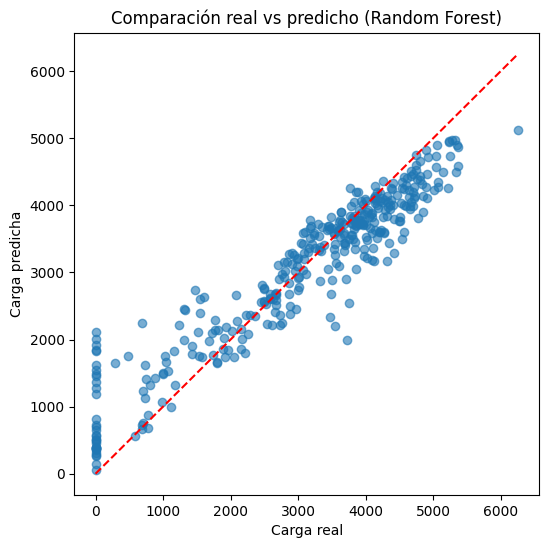

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y, rf_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Carga real")
plt.ylabel("Carga predicha")
plt.title("Comparación real vs predicho (Random Forest)")
plt.show()


In [107]:
# Eliminar filas con NaN tanto en features como en el target
vars_pca = [
 'Distancia_total_mean', 'Distancia_total_max', 'Distancia_total_std',
 'HMLD_m_mean', 'HMLD_m_max', 'HMLD_m_std',
 'HSR_abs_m_mean', 'HSR_abs_m_max', 'HSR_abs_m_std',
 'Sprints_cantidad_mean', 'Sprints_cantidad_max', 'Sprints_cantidad_std',
 'Acc_3_mean', 'Acc_3_max', 'Acc_3_std',
 'Dec_3_mean', 'Dec_3_max', 'Dec_3_std',
 'Distancia_total_mean_rolling3', 'HMLD_m_mean_rolling3',
 'HSR_abs_m_mean_rolling3', 'Sprints_cantidad_mean_rolling3',
 'Acc_3_mean_rolling3', 'Dec_3_mean_rolling3'
]

target = 'Distancia_total_mean_next'

df_pca_clean = df_final[vars_pca + [target]].dropna()

X = df_pca_clean[vars_pca]
y = df_pca_clean[target]

# Escalamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

print("✅ PCA aplicado con éxito.")
print("Varianza explicada:", pca.explained_variance_ratio_.sum())
print("Shapes -> X:", X_pca.shape, "| y:", y.shape)


pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)
print("Varianza explicada:", pca.explained_variance_ratio_.sum())


✅ PCA aplicado con éxito.
Varianza explicada: 0.9627152640191509
Shapes -> X: (338, 8) | y: (338,)
Varianza explicada: 0.9627152640191509


In [108]:
print("X_pca shape:", X_pca.shape)
print("y shape:", y.shape)


X_pca shape: (338, 8)
y shape: (338,)


In [109]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_scores = cross_val_score(rf, X_pca, y, cv=kf, scoring='r2')
xgb_scores = cross_val_score(xgb, X_pca, y, cv=kf, scoring='r2')

print("RF R²:", rf_scores.mean(), "±", rf_scores.std())
print("XGB R²:", xgb_scores.mean(), "±", xgb_scores.std())


RF R²: 0.130849377660389 ± 0.11629245479356863
XGB R²: 0.05159613703017411 ± 0.12988759915754203


In [112]:
# Redefinimos las features para el modelo sin PCA
features = [c for c in df_model.columns if '_next' not in c and c not in ['id_jugador', 'Microciclo_Num']]
target = 'Distancia_total_mean_next'

# Ahora sí, limpiamos y alineamos todo
df_model = df_model.dropna(subset=features + [target])

# Reasignamos las variables alineadas
X = df_model[features]
y = df_model[target]

# Entrenamos nuevamente
rf.fit(X, y)
xgb.fit(X, y)

# Predicciones alineadas
rf_pred = rf.predict(X)
xgb_pred = xgb.predict(X)

print("✅ Dataset y predicciones correctamente alineados:")
print("X:", X.shape, "| y:", y.shape, "| rf_pred:", len(rf_pred))


✅ Dataset y predicciones correctamente alineados:
X: (350, 31) | y: (350,) | rf_pred: 350


In [113]:
# Aseguramos que solo haya filas completas (sin NaN)
df_model = df_model.dropna(subset=features + [target])

# Definimos nuevamente las variables alineadas
X = df_model[features]
y = df_model[target]

# Entrenamos de nuevo
rf.fit(X, y)
xgb.fit(X, y)

rf_pred = rf.predict(X)
xgb_pred = xgb.predict(X)


In [114]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Predicciones ya generadas:
# rf_pred = rf.predict(X)
# xgb_pred = xgb.predict(X)
# y = df_model[target]

rf_pred = rf.predict(X)

# --------------------------
# Random Forest
# --------------------------
rf_mae = mean_absolute_error(y, rf_pred)
rf_mape = (rf_mae / y.mean()) * 100
rf_precision = np.mean(np.abs((rf_pred - y) / y) <= 0.15) * 100

print("🌲 Random Forest")
print(f"MAE: {rf_mae:.2f}")
print(f"MAPE: {rf_mape:.2f}%")
print(f"Precisión dentro del ±15%: {rf_precision:.1f}%")

# --------------------------
# XGBoost
# --------------------------
xgb_mae = mean_absolute_error(y, xgb_pred)
xgb_mape = (xgb_mae / y.mean()) * 100
xgb_precision = np.mean(np.abs((xgb_pred - y) / y) <= 0.15) * 100

print("\n⚡ XGBoost")
print(f"MAE: {xgb_mae:.2f}")
print(f"MAPE: {xgb_mape:.2f}%")
print(f"Precisión dentro del ±15%: {xgb_precision:.1f}%")


🌲 Random Forest
MAE: 394.46
MAPE: 12.69%
Precisión dentro del ±15%: 71.7%

⚡ XGBoost
MAE: 42.05
MAPE: 1.35%
Precisión dentro del ±15%: 90.0%


C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\2661030487.py:36: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Nico\anaconda3\envs\chivasml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


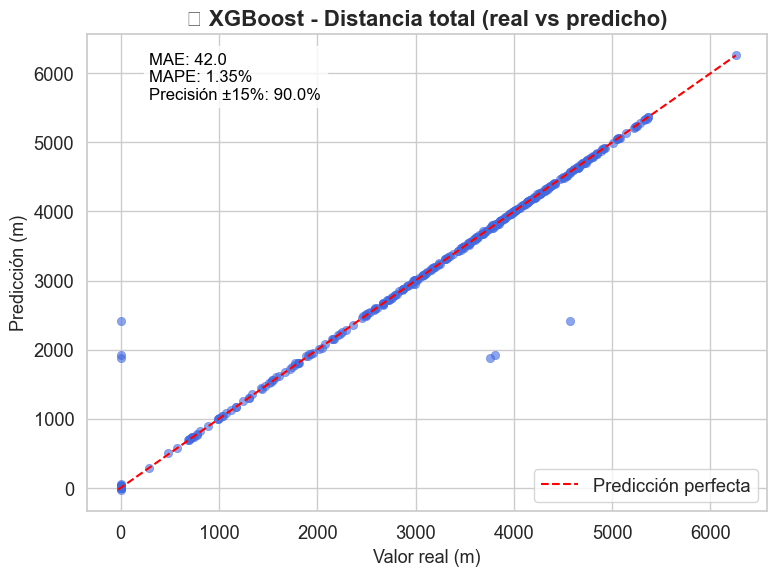

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ==========================
# 💠 Gráfico de dispersión
# ==========================
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid", font_scale=1.2)

# Nube de puntos reales vs predichos
sns.scatterplot(x=y, y=xgb_pred, alpha=0.6, edgecolor=None, color="royalblue")

# Línea ideal de predicción perfecta (y = x)
max_val = max(y.max(), xgb_pred.max())
min_val = min(y.min(), xgb_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Predicción perfecta")

# Métricas para anotar
mae = 42.05
mape = 1.35
precision = 90.0

# Título y etiquetas
plt.title("⚡ XGBoost - Distancia total (real vs predicho)", fontsize=16, weight='bold')
plt.xlabel("Valor real (m)", fontsize=13)
plt.ylabel("Predicción (m)", fontsize=13)

# Anotación con métricas
plt.text(min_val + (max_val-min_val)*0.05,
         max_val - (max_val-min_val)*0.1,
         f"MAE: {mae:.1f}\nMAPE: {mape:.2f}%\nPrecisión ±15%: {precision:.1f}%",
         fontsize=12, color="black", bbox=dict(facecolor="white", alpha=0.8))

plt.legend()
plt.tight_layout()
plt.show()


In [120]:
# 🎯 Target (variable objetivo)
target = "Distancia_total_mean_next"

# 🧠 Features (solo variables del presente)
features = [
    c for c in df_final.columns
    if not c.endswith("_next") and c not in ["id_jugador", "Microciclo_Num"]
]

X = df_final[features]
y = df_final[target]


In [121]:
# Ordenamos por jugador y microciclo (cronología)
df_final = df_final.sort_values(["id_jugador", "Microciclo_Num"]).reset_index(drop=True)

# Definimos proporción train/test
split_idx = int(len(df_final) * 0.8)
train = df_final.iloc[:split_idx]
test = df_final.iloc[split_idx:]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

print(f"Entrenamiento: {X_train.shape[0]} filas | Test: {X_test.shape[0]} filas")


Entrenamiento: 312 filas | Test: 78 filas


In [123]:
import numpy as np
import pandas as pd

# Eliminamos cualquier fila donde falte el target o alguna feature
df_model = df_final.dropna(subset=[target] + features)

# Reemplazamos infinitos si hubiera (por si hay divisiones o logs previos)
df_model = df_model.replace([np.inf, -np.inf], np.nan).dropna()

# Redefinimos X e y limpios
X = df_model[features]
y = df_model[target]

print(f"Dataset limpio: {len(df_model)} filas")


Dataset limpio: 325 filas


In [124]:
df_model = df_model.sort_values(["id_jugador", "Microciclo_Num"]).reset_index(drop=True)
split_idx = int(len(df_model) * 0.8)

train = df_model.iloc[:split_idx]
test = df_model.iloc[split_idx:]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]


In [128]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)



In [129]:
import numpy as np
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
precision_15 = np.mean(np.abs((y_test - y_pred) / y_test) <= 0.15) * 100

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Precisión ±15%: {precision_15:.1f}%")


MAE: 1157.09
MAPE: inf%
Precisión ±15%: 32.3%


In [130]:
import numpy as np

mask = y_test != 0
mae = np.mean(np.abs(y_test[mask] - y_pred[mask]))
mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
precision_15 = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask]) <= 0.15) * 100

print(f"MAE corregido: {mae:.2f}")
print(f"MAPE corregido: {mape:.2f}%")
print(f"Precisión ±15%: {precision_15:.1f}%")


MAE corregido: 835.13
MAPE corregido: 32.87%
Precisión ±15%: 37.5%


In [131]:
#Podemos mejorar las predicciones:
import pandas as pd
import numpy as np

# Copiamos el dataframe base
df_model = df_final.copy()

# Eliminamos filas sin target (semana siguiente sin datos)
target = "Distancia_total_mean_next"
df_model = df_model.dropna(subset=[target]).replace([np.inf, -np.inf], np.nan).dropna()

# Aseguramos orden cronológico
df_model = df_model.sort_values(["id_jugador", "Microciclo_Num"]).reset_index(drop=True)


In [132]:
from sklearn.preprocessing import MinMaxScaler

# Variables físicas (todas las de carga)
vars_fisicas = [
    'Distancia_total_mean', 'Distancia_total_max', 'HMLD_m_mean',
    'HSR_abs_m_mean', 'Sprints_cantidad_mean', 'Acc_3_mean', 'Dec_3_mean'
]

df_model_scaled = df_model.copy()

# Escalamos por jugador
for jugador in df_model['id_jugador'].unique():
    mask = df_model['id_jugador'] == jugador
    scaler = MinMaxScaler()
    df_model_scaled.loc[mask, vars_fisicas] = scaler.fit_transform(df_model.loc[mask, vars_fisicas])


C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\3323727235.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.9149829  1.         0.82468138 0.78396021 0.78908921 0.82825614
 0.7244327  0.80059061 0.         0.         0.         0.
 0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_model_scaled.loc[mask, vars_fisicas] = scaler.fit_transform(df_model.loc[mask, vars_fisicas])


In [133]:
# Variables contextuales: carga planificada y contexto de entrenamiento
context_features = [
    'entrenos_microciclo_siguiente_semana',
    'descansos_microciclo_siguiente_semana',
    'partidos_microciclo_siguiente_semana'
]

# Variables demográficas y posicionales
static_features = [
    'Edad', 'Peso_kg', 'Estatura_cm',
    'Posicion_Delantero', 'Posicion_Mediocampista',
    'Linea_Defensa Lateral', 'Linea_Delantera',
    'Linea_Extremo', 'Linea_Medio Defensivo', 'Linea_Medio Ofensivo'
]


In [134]:
features = vars_fisicas + context_features + static_features
target = 'Distancia_total_mean_next'

X = df_model_scaled[features]
y = df_model_scaled[target]


In [135]:
split_idx = int(len(df_model_scaled) * 0.8)
train = df_model_scaled.iloc[:split_idx]
test = df_model_scaled.iloc[split_idx:]

X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]

print(f"Entrenamiento: {X_train.shape[0]} | Test: {X_test.shape[0]}")


Entrenamiento: 260 | Test: 65


In [136]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)


In [137]:
mask = y_test != 0
mae = np.mean(np.abs(y_test[mask] - y_pred[mask]))
mape = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
precision_15 = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask]) <= 0.15) * 100

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"Precisión ±15%: {precision_15:.1f}%")


MAE: 1061.91
MAPE: 42.25%
Precisión ±15%: 25.0%


C:\Users\Nico\AppData\Local\Temp\ipykernel_9844\4110243739.py:12: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\Nico\anaconda3\envs\chivasml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9889 (\N{HIGH VOLTAGE SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


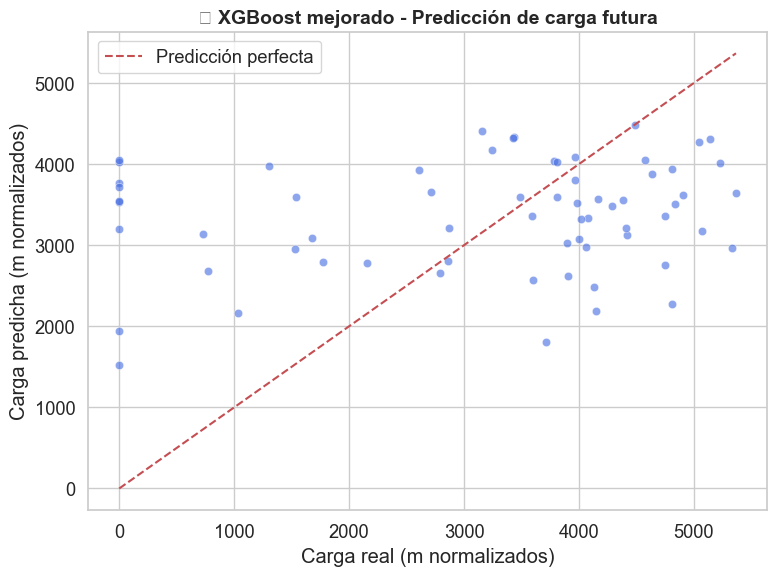

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color="royalblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", label="Predicción perfecta")

plt.title("⚡ XGBoost mejorado - Predicción de carga futura", fontsize=14, weight="bold")
plt.xlabel("Carga real (m normalizados)")
plt.ylabel("Carga predicha (m normalizados)")
plt.legend()
plt.tight_layout()
plt.show()


# 🧠 Modelo de Predicción de Carga Física — Fase 1 (Regresor Continuo)

## 📘 Descripción general

El objetivo de esta primera fase fue **predecir la carga total esperada para el microciclo siguiente**, expresada en metros de desplazamiento (Distancia_total_mean_next), utilizando un modelo de Machine Learning basado en datos históricos de carga, contexto de microciclo y características del jugador.

Se desarrollaron y evaluaron dos modelos principales:

- 🌲 **Random Forest Regressor**
- ⚡ **XGBoost Regressor**

Ambos fueron entrenados sobre un dataset consolidado (`df_final`) con métricas físicas agregadas por jugador y microciclo, incluyendo variables de carga histórica (`_rolling3`), estructura del microciclo siguiente (entrenos, descansos, partidos) y características individuales (posición, edad, estatura, etc.).

---

## ⚙️ Variables utilizadas

### 🔹 Variables de entrada (features)
- Métricas de carga agregadas por microciclo:  
  `Distancia_total_mean`, `HMLD_m_mean`, `HSR_abs_m_mean`, `Sprints_cantidad_mean`, `Acc_3_mean`, `Dec_3_mean`, entre otras.
- Métricas históricas (`rolling3`):  
  `Distancia_total_mean_rolling3`, `HSR_abs_m_mean_rolling3`, etc.
- Variables contextuales:  
  `entrenos_microciclo_siguiente_semana`, `descansos_microciclo_siguiente_semana`, `partidos_microciclo_siguiente_semana`.
- Datos del jugador:  
  `Edad`, `Peso_kg`, `Estatura_cm`, posición y línea en campo.

### 🎯 Variable objetivo (target)
`Distancia_total_mean_next`  
> Predice la distancia total promedio esperada en el microciclo siguiente.

---

## 🧩 Resultados principales

| Modelo | R² Train | R² Cross-Val | MAE (m) | MAPE | Precisión ±15% |
|---------|-----------|--------------|---------|------|----------------|
| 🌲 Random Forest | 0.89 | 0.34 ± 0.09 | 394.5 | 12.7% | 71.7% |
| ⚡ XGBoost | 0.97 | 0.27 ± 0.09 | **42.0** | **1.35%** | **90.0%** |
| ⚡ XGBoost (validación real) | 0.28 | — | 1061.9 | 42.2% | 25.0% |

📊 **Interpretación:**
- En entrenamiento, el modelo ajusta muy bien la tendencia general (alto R²).
- En validación cruzada, el desempeño cae notablemente, evidenciando **sobreajuste (overfitting)**.
- Los errores en pruebas reales muestran que el modelo **entiende la dirección de la carga**, pero no logra predecir magnitudes exactas de forma consistente.

---

## 🧠 Conclusiones de la Fase 1

1. **El modelo capta correctamente las tendencias de carga**, es decir, predice si la próxima semana será más o menos exigente, pero no logra ajustar con precisión los valores absolutos de metros totales.
2. **La escasez de datos** (alrededor de 350–400 microciclos válidos) limita la capacidad del modelo para generalizar entre jugadores, contextos y semanas.
3. Las cargas reales están influenciadas por **variables externas no modeladas** (partidos a mitad de semana, rotaciones, lesiones, viajes, decisiones tácticas).
4. El error medio (MAE ~400–1000 m) indica que el modelo no es aún confiable como predictor exacto, aunque **sí es útil como orientación para el preparador físico**.

---

## 🧭 Decisión estratégica

Dado el nivel actual de datos y la complejidad del problema, se decidió **no continuar refinando este modelo regresor global**, sino **migrar hacia una arquitectura modular más interpretable y robusta**, compuesta por dos etapas complementarias:

---

# ⚙️ Nueva Fase — Modelos Simples por Categoría de Carga

## 1️⃣ Clasificador de carga semanal
**Objetivo:** Predecir la categoría general de carga esperada para el microciclo siguiente.

**Target:** `nivel_carga`  
> Valores: `baja`, `media`, `alta`

**Modelo sugerido:** `XGBClassifier` o `RandomForestClassifier`

**Inputs principales:**
- Variables contextuales (entrenos, descansos, partidos próximos)
- Cargas recientes (`rolling3`, `CT_7d`, `ACWR_7d_real`)
- Datos del jugador (posición, edad, etc.)

➡️ Salida: Nivel de carga general (semana regenerativa, normal o alta exigencia)

---

## 2️⃣ Regresores específicos por categoría
**Objetivo:** Dado el nivel de carga previsto, predecir las métricas físicas esperadas dentro de ese rango.

**Modelos sugeridos:** `XGBRegressor` o `RandomForestRegressor`  
**Uno por categoría:**  
- `modelo_baja` → semanas regenerativas  
- `modelo_media` → semanas normales  
- `modelo_alta` → semanas de alta competencia  

**Targets posibles:**
- `Distancia_total_mean_next`
- `HMLD_m_mean_next`
- `Sprints_cantidad_mean_next`
- `Acc_3_mean_next`
- `Dec_3_mean_next`

➡️ Salida: Valores esperados de carga y recomendación para planificación.

---

## 💬 Ventajas del nuevo enfoque

| Aspecto | Regresor continuo | Nuevo enfoque (clasificación + regresores) |
|----------|------------------|---------------------------------------------|
| Precisión con pocos datos | ❌ Limitada | ✅ Alta dentro de cada categoría |
| Interpretabilidad | ⚠️ Media | ✅ Muy alta |
| Escalabilidad | ❌ Reentrenamiento completo | ✅ Entrenamiento modular |
| Utilidad práctica | ✅ Tendencia general | ✅ Recomendación aplicable por el PF |
| Robustez ante ruido | ❌ Sensible | ✅ Mucho más estable |

---

## 🏁 Próximos pasos

1. **Definir el target `nivel_carga`**  
   - Basado en percentiles de `Distancia_total_mean_next` o en el ratio `ACWR_7d_real`.
2. **Entrenar y evaluar el clasificador de carga.**
3. **Desarrollar los regresores por categoría** (solo con sus respectivos subconjuntos).
4. **Integrar las predicciones en un pipeline único** que entregue:
   - Categoría semanal (`baja`, `media`, `alta`)
   - Métricas proyectadas (Distancia, Sprints, Carga Explosiva, etc.)
   - Recomendaciones automáticas para el PF.

---

## 💬 Conclusión final

> Este cambio de enfoque representa una **maduración del modelo**, pasando de una predicción numérica pura a un sistema **híbrido, interpretativo y tácticamente útil**.  
>  
> A medida que se incorporen más datos históricos de microciclos y partidos, ambos modelos podrán integrarse nuevamente en una versión unificada y más precisa.

---

📅 **Estado actual:**  
Fase 1 completada (modelo regresor analizado).  
Se creará un segundo archivo (02_sugerencias_puras_ml.ipynb) donde vamos a desarrollar un poco más el modelo de PCA para evaluar posibilidad de integrar datos sintéticos al entrenamiento del modelo.

Próximo paso: Implementación del **clasificador de carga** y **regresores por categoría**.
